In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 29.6 MB/s eta 0:00:00


In [2]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 29.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
import os
import glob
import shutil
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    Rotate, HueSaturationValue, RGBShift
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
augmentation = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
    Rotate(limit=15, p=0.5),
    HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.5),
    RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5)
], bbox_params={'format': 'yolo', 'label_fields': ['class_labels']})

In [6]:
INPUT_DIR = '/kaggle/input/inmemaske-1-1/inmemaske'
DATASET_DIR = '/kaggle/working/dataset'

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DATASET_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, split, 'labels'), exist_ok=True)

In [7]:
def process_pair(pair, split, apply_augmentation=False):
    maskeli_path, maskesiz_path = pair
    base_name = os.path.basename(maskeli_path)
    
    # Görüntüleri yükle
    maskeli = cv2.imread(maskeli_path)
    maskesiz = cv2.imread(maskesiz_path)
    
    if maskeli is None or maskesiz is None:
        print(f"Hata! Görüntü okunamadı: {maskeli_path}")
        return

    # Fark maskesi oluştur
    diff = cv2.absdiff(maskeli, maskesiz)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Kontur işlemleri
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_boxes = []
    
    for cnt in contours:
        if cv2.contourArea(cnt) < 100:
            continue
            
        x,y,w,h = cv2.boundingRect(cnt)
        x_center = (x + w/2) / 512
        y_center = (y + h/2) / 512
        width = w / 512
        height = h / 512
        
        if (x_center + width/2) > 1.0 or (y_center + height/2) > 1.0:
            continue
            
        valid_boxes.append([x_center, y_center, width, height])

    if not valid_boxes:
        return
    
    # Sadece eğitim verilerine augmentasyon uygula
    if apply_augmentation:
        augmented = augmentation(
            image=maskesiz,
            bboxes=valid_boxes,
            class_labels=[0]*len(valid_boxes)
        )
        image = augmented['image']
        bboxes = augmented['bboxes']
    else:
        image = maskesiz
        bboxes = valid_boxes
    
    # Görüntüyü ve etiketleri kaydet
    cv2.imwrite(f'{DATASET_DIR}/{split}/images/{base_name}', image)
    with open(f'{DATASET_DIR}/{split}/labels/{base_name.replace(".png", ".txt")}', 'w') as f:
        for bbox in bboxes:
            f.write(f"0 {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")


In [8]:
def create_yolo_dataset():
    # Veri yollarını topla
    maskeli_images = glob.glob(f'{INPUT_DIR}/maskeli/**/*.png', recursive=True)
    image_pairs = []
    
    # Eşleştirme yap
    for maskeli_path in maskeli_images:
        category = 'iskemik' if 'iskemik' in maskeli_path else 'kanamali'
        base_name = os.path.basename(maskeli_path)
        maskesiz_path = f"{INPUT_DIR}/maskesiz/{category}/{base_name}"
        
        if os.path.exists(maskesiz_path):
            image_pairs.append((maskeli_path, maskesiz_path))
    
    # Veriyi böl
    random.shuffle(image_pairs)
    train_size = int(0.7 * len(image_pairs))
    val_size = int(0.15 * len(image_pairs))
    
    train_pairs = image_pairs[:train_size]
    val_pairs = image_pairs[train_size:train_size+val_size]
    test_pairs = image_pairs[train_size+val_size:]
    
    # Veriyi işle
    for pair in train_pairs:
        process_pair(pair, 'train', apply_augmentation=True)
        
    for pair in val_pairs:
        process_pair(pair, 'val')
        
    for pair in test_pairs:
        process_pair(pair, 'test')
    
    print(f"Oluşturulan veri: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")

create_yolo_dataset()


Oluşturulan veri: Train=1556, Val=333, Test=334


In [10]:
yaml_content = f"""
path: {DATASET_DIR}
train: train/images
val: val/images
test: test/images

names:
  0: stroke
"""

with open(f'{DATASET_DIR}/dataset.yaml', 'w') as f:
    f.write(yaml_content)

In [23]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


In [24]:
model = YOLO('yolov8m.pt')

results = model.train(
    data=f'{DATASET_DIR}/dataset.yaml',
    epochs=50,
    imgsz=512,
    batch=16,
    patience=30,
    optimizer='SGD',
    momentum=0.93,
    weight_decay=0.0005,
    lr0=0.001,
    lrf=0.01,
    warmup_epochs=3,
    warmup_momentum=0.8,
    hsv_h=0.3,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.5,
    mosaic=1.0,
    box=0.05,
    cls=0.5
)

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=50, time=None, patience=30, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /kaggle/working/dataset/train/labels.cache... 1554 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1554/1554 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/dataset/val/labels.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.93) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.0162      3.625      2.123          6        512: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]


                   all        331        433      0.338      0.162      0.133     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G    0.01419      2.512      1.955          1        512: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.23it/s]

                   all        331        433      0.546      0.326      0.347      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G    0.01249      2.004      1.766          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

                   all        331        433      0.686       0.43      0.494      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G    0.01171      1.672      1.643          7        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        331        433       0.72       0.45       0.53      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G    0.01145      1.559      1.579          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.17it/s]

                   all        331        433      0.734      0.478      0.567      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G    0.01126      1.459      1.541          4        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.715      0.566      0.623      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G    0.01095       1.39      1.503          8        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

                   all        331        433      0.773      0.526      0.618      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G    0.01085       1.34      1.481          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

                   all        331        433      0.755      0.538       0.62      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G    0.01082      1.355      1.495          4        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.793      0.561      0.664      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G    0.01072      1.299      1.488          4        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

                   all        331        433      0.809      0.584      0.672      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G    0.01032      1.222      1.437          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.805      0.522      0.643      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G    0.01039       1.22      1.423          5        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.753       0.58      0.663      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G    0.01033      1.237      1.419          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

                   all        331        433      0.827      0.575      0.686      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G    0.01038      1.202      1.436          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        331        433      0.663      0.589      0.608      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G    0.01031      1.176      1.402         10        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.782      0.614      0.688      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G    0.01028       1.15      1.404          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

                   all        331        433      0.803      0.593      0.696      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G    0.01013      1.108      1.396          5        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        331        433      0.766      0.612      0.693      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G    0.01004      1.093      1.371          4        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.23it/s]

                   all        331        433      0.786      0.596      0.697      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G    0.01001      1.082      1.371          5        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.789      0.607      0.693       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G   0.009918      1.074      1.373          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.816      0.577      0.699      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G    0.01002      1.073      1.387          5        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.733      0.614       0.69       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G   0.009901      1.082      1.395          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.791      0.598      0.706      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G    0.01022      1.119      1.413          1        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.20it/s]

                   all        331        433      0.763      0.618      0.703      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G   0.009685      1.025      1.361          1        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        331        433      0.783      0.591      0.687       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G   0.009691      1.009       1.36          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        331        433      0.765       0.61      0.693      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G   0.009769      1.033      1.356          6        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        331        433      0.817      0.589      0.703      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G   0.009705      1.015      1.366          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]

                   all        331        433      0.805      0.628      0.727      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G   0.009729     0.9783      1.346          9        512: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

                   all        331        433      0.775      0.633       0.71      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G   0.009471     0.9571      1.334          9        512: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        331        433      0.759      0.649      0.715      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G   0.009394     0.9599      1.343          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.23it/s]

                   all        331        433      0.794      0.612      0.711      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G   0.009354     0.9449      1.323          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.818      0.612      0.712      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G   0.009534     0.9455      1.338          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.816      0.594      0.713      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G   0.009241     0.9278      1.324          4        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        331        433      0.783      0.612      0.702      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G   0.009277     0.9372      1.334          1        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.823      0.603      0.707      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G   0.009262     0.9368      1.324          7        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.733      0.641      0.699      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G   0.009244     0.9196      1.333          6        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

                   all        331        433      0.763      0.633      0.709      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G   0.009337     0.9465      1.316          1        512: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.777      0.656      0.712      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G   0.008951     0.8823      1.292          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.27it/s]

                   all        331        433      0.748      0.661      0.725      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G   0.009078     0.8975      1.301          4        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]

                   all        331        433      0.783      0.641       0.72      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G   0.009055     0.9211      1.293          1        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        331        433      0.772      0.639      0.727      0.467


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G   0.008748      0.802      1.287          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

                   all        331        433      0.794      0.624      0.713      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G   0.008663       0.76       1.29          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

                   all        331        433      0.802      0.617       0.72      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G    0.00859      0.758      1.288          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

                   all        331        433      0.777      0.629      0.724      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G   0.008613      0.731      1.283          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

                   all        331        433      0.786      0.644      0.729      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G    0.00848     0.7212      1.284          6        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

                   all        331        433      0.823      0.619       0.73      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G    0.00841     0.7267      1.282          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

                   all        331        433      0.841      0.628      0.733      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G   0.008455     0.7151      1.274          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

                   all        331        433      0.843      0.634      0.737      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G   0.008495     0.7126      1.281          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        331        433      0.836      0.647      0.738      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G   0.008383     0.7351      1.272          3        512: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        331        433      0.829      0.644      0.735      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G   0.008439     0.7067      1.264          2        512: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.14it/s]

                   all        331        433      0.839      0.651      0.744      0.472



50 epochs completed in 0.525 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 52.0MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


                   all        331        433      0.835      0.651      0.745      0.471


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 6.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train7


In [25]:
metrics = model.val()
print(f"Model performansı: mAP50-95: {metrics.box.map}")

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/dataset/val/labels.cache... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]


                   all        331        433      0.836      0.651      0.744      0.473


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 14.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train72
Model performansı: mAP50-95: 0.47253843149662744



image 1/1 /kaggle/working/dataset/test/images/16876.png: 512x512 1 stroke, 24.8ms
Speed: 1.2ms preprocess, 24.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


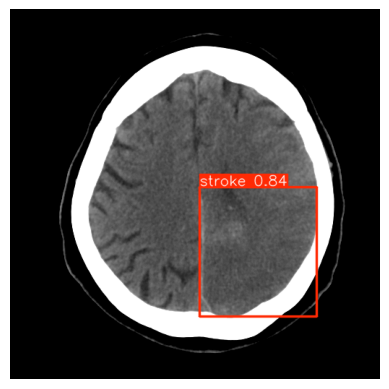


image 1/1 /kaggle/working/dataset/test/images/14538.png: 512x512 2 strokes, 24.9ms
Speed: 1.3ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)


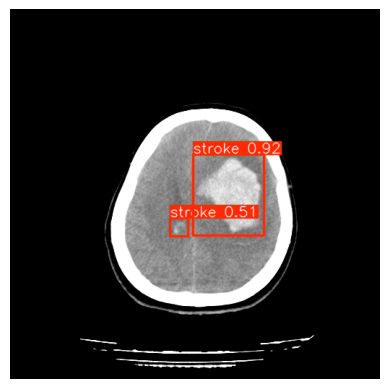


image 1/1 /kaggle/working/dataset/test/images/13255.png: 512x512 1 stroke, 24.9ms
Speed: 1.2ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)


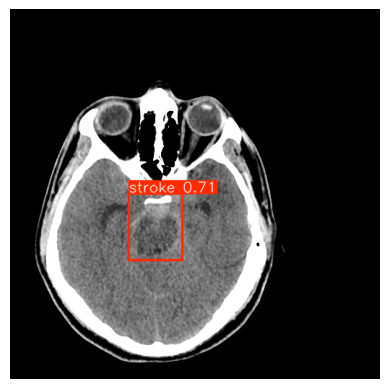

In [ ]:
test_images = glob.glob(f'{DATASET_DIR}/test/images/*.png')[:3]

for img_path in test_images:
    results = model.predict(img_path, conf=0.5)
    plotted = results[0].plot()
    plt.imshow(plotted)
    plt.axis('off')
    plt.show()